In [1]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [50]:
test_data.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ("imputer", SimpleImputer(strategy="median")),
])

In [13]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [14]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [17]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [18]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [19]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [20]:
y_train = train_data["Survived"]

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [23]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [48]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

In [49]:
forest_scores.shape, forest_scores[:5]
forest_scores, svm_scores
forest_scores.max(), svm_scores.max()

(0.8876404494382022, 0.8089887640449438)

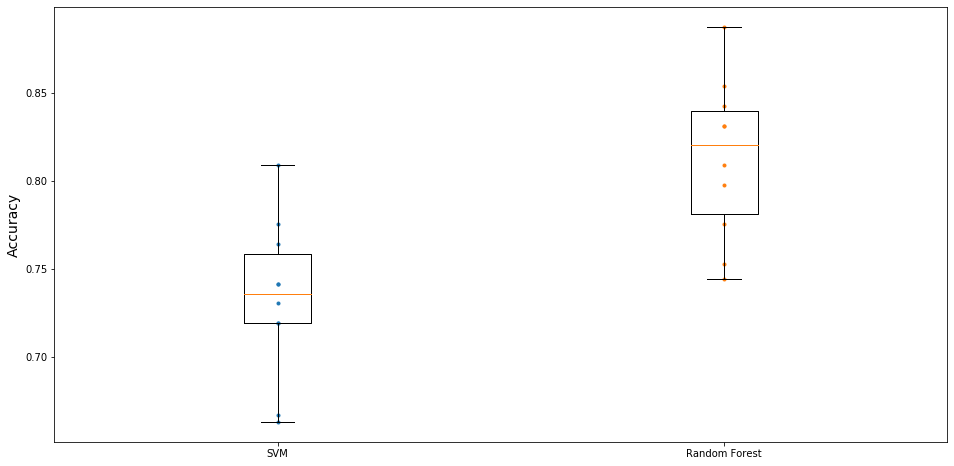

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [27]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [28]:
train_data["AgeBucket"]

0      15.0
1      30.0
2      15.0
3      30.0
4      30.0
       ... 
886    15.0
887    15.0
888     NaN
889    15.0
890    30.0
Name: AgeBucket, Length: 891, dtype: float64

In [29]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [30]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=10)
sgd_scores.mean()

0.6936704119850188

In [31]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [32]:
X_train[:2]

array([[22.    ,  1.    ,  0.    ,  7.25  ,  0.    ,  0.    ,  1.    ,
         0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ,  0.    ,  0.    ,
         1.    ,  0.    ,  1.    ,  0.    ,  0.    ]])

In [33]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'AgeBucket',
       'RelativesOnboard'],
      dtype='object')

In [34]:
from sklearn.preprocessing import normalize

In [35]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [36]:
scaler = StandardScaler()

In [37]:
param_grid = [
    {"loss":["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
     "penalty":["l2", "l1"],
     "alpha":[0.0001, 0.001, 0.01],}
]

sgd_clf = SGDClassifier()
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01],
                          'loss': ['hinge', 'log', 'modified_huber',
                                   'squared_hinge', 'perceptron'],
                 

In [38]:
grid_search.best_params_

{'alpha': 0.001, 'loss': 'perceptron', 'penalty': 'l1'}

In [39]:
grid_search.best_score_

0.7800075324838366

In [44]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[
    ("random_forest", forest_clf),
    ("sgd", grid_search),
    ("svm", svm_clf)
], voting="hard")

eclf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished


VotingClassifier(estimators=[('random_forest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.

In [45]:
eclf_scores = cross_val_score(eclf, X_train, y_train, cv=10)
eclf_scores.mean()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished


0.8059051186017477

In [51]:
X_test = preprocess_pipeline.fit_transform(test_data)
X_test

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       [62. ,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [27. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

In [52]:
y_pred = eclf.predict(X_test)

In [54]:
y_pred.shape, X_test.shape

((418,), (418, 12))

In [55]:
result_example = load_titanic_data("gender_submission.csv")

In [56]:
result_example.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [69]:
list(test_data["PassengerId"].unique()) == list(range(892, 1310))

True

In [72]:
results = pd.DataFrame(np.c_[test_data["PassengerId"], y_pred], columns=["PassengerId", "Survived"])

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [73]:
results.shape, result_example.shape

((418, 2), (418, 2))

In [77]:
results.to_csv("titanic_results_majority_voting_v1.csv", index=False)

In [75]:
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [76]:
result_example.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


#### Kaggle accuracy score: 0.72248